In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.platform import gfile

import functools

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, pickle

import str_ww_util as util
import keras_model as models

from IPython import display

/Users/jeremy/miniforge3/envs/jh_main/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rng = np.random.default_rng(2024)

In [50]:
from get_dataset import decode_audio, get_label, get_waveform_and_label, \
                        convert_labels_str2int, convert_to_int16, cast_and_pad, \
                        convert_dataset, get_preprocess_audio_func, prepare_background_data, \
                        get_training_data, count_labels, is_batched

In [8]:
Flags, unparsed = util.parse_command()

In [61]:
# Flags.num_train_samples = 100
# Flags.num_val_samples = 100
# Flags.num_test_samples = 100

load_pretrained_model = True # True to load 
pretrained_model_path = 'trained_models/ref_model.h5'

Flags.data_dir = os.path.join(os.getenv('HOME'), 'data', 'speech_commands_files_0.2')
Flags.bg_path = Flags.data_dir

get_waves = False

BACKGROUND_NOISE_DIR_NAME='_background_noise_' 
background_data = prepare_background_data(Flags.bg_path,BACKGROUND_NOISE_DIR_NAME)



In [10]:
# ds_train, ds_test, ds_val = get_training_data(Flags)

label_count=3
background_frequency = Flags.background_frequency
background_volume_range_= Flags.background_volume
model_settings = models.prepare_model_settings(label_count, Flags)

In [11]:

## Code for loading data from pre-built dataset.  We're loading from files,
## because we need the 'marvin' keyword
# splits = ['train', 'test', 'validation']
# (ds_train, ds_test, ds_val), ds_info = tfds.load('speech_commands:0.0.2', split=splits, 
#                                               data_dir=Flags.data_dir, with_info=True)
## class 10 = background noise
## class 11 = 'other words'

In [12]:
# max_count = 5
# count = 0
# for dat in ds_train:
#   # print(dat['label'])
#   if dat['label'].numpy() == 10: 
#     count += 1
#     display.display(display.Audio(dat['audio'].numpy(), rate=16000))
#     if count >= max_count:
#       break
# # display.display(display.Audio(dat['audio'].numpy(), rate=16000))

#### Build Dataset from Files
Right here is where we should build a dataset from files.
each dataset element should be {'audio':<waveform>, 'label':<integer_label>}

In [13]:
data_dir = Flags.data_dir

In [14]:
import glob
filenames = glob.glob(os.path.join(str(data_dir), '*', '*.wav'))

In [15]:
# the full speech-commands set lists which files are to be used
# as test and validation data; train with everything else
data_dir = Flags.data_dir
fname_val_files = os.path.join(data_dir, 'validation_list.txt')    
with open(fname_val_files) as fpi_val:
  val_files = fpi_val.read().splitlines()
# validation_list.txt only lists partial paths, append to data_dir and sr
val_files = [os.path.join(data_dir, fn).rstrip() for fn in val_files]

# repeat for test files
fname_test_files = os.path.join(data_dir, 'testing_list.txt')
with open(fname_test_files) as fpi_tst:
  test_files = fpi_tst.read().splitlines()  
test_files = [os.path.join(data_dir, fn).rstrip() for fn in test_files]    
  
if os.sep != '/': 
  # the files validation_list.txt and testing_list.txt use '/' as path separator
  # if we're on a windows machine, replace the '/' with the correct separator
  val_files = [fn.replace('/', os.sep) for fn in val_files]
  test_files = [fn.replace('/', os.sep) for fn in test_files]

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

# don't train with the _background_noise_ files; exclude when directory name starts with '_'
train_files = [f for f in filenames if f.split(os.sep)[-2][0] != '_']
# validation and test files are listed explicitly in *_list.txt; train with everything else
train_files = list(set(train_files) - set(test_files) - set(val_files))
# now convert into a TF tensor so we can use the tf.dataset pipeline
train_files = tf.constant(train_files)


ds_train = tf.data.Dataset.from_tensor_slices(train_files)
ds_train = ds_train.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(convert_labels_str2int)

ds_val = tf.data.Dataset.from_tensor_slices(val_files)
ds_val = ds_val.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(convert_labels_str2int)

ds_test = tf.data.Dataset.from_tensor_slices(test_files)
ds_test = ds_test.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(convert_labels_str2int)

In [17]:
print("One element from the training set:")
for dat in ds_train.take(1):
  input_shape = dat['audio'].shape # we'll also need this to build the silent dataset
  print(f"Input tensor shape: {input_shape}")  
  print(f"Label = {dat['label']}; shape = {dat['label'].shape}")
  break
example_wav = dat['audio']

One element from the training set:
Input tensor shape: (12632,)
Label = 2; shape = ()


In [18]:
# create a few copies of only the target words to balance the distribution
# create a tmp dataset with only the target words
ds_only_target = ds_train.filter(lambda dat: dat['label'] == 0)

In [19]:
# print("Five elements from the only-target set:")
# for dat in ds_only_target.take(5):
#   print(f"Input tensor shape: {dat['audio'].shape}")  
#   print(f"Label = {dat['label']}; shape = {dat['label'].shape}")


In [20]:
# # different way to build the silent dataset
# rand_waves = rng.normal(loc=0.0, scale=0.3, size=(num_silent,)+tuple(input_shape))
# silent_index = 1
# silent_wave_ds = tf.data.Dataset.from_tensor_slices(rand_waves)
# silent_wave_ds = silent_wave_ds.map(lambda x: {'audio':x,'label':1})
# silent_wave_ds = silent_wave_ds.map(lambda dd: {'audio':dd['audio'],'label':dd['label']})


In [21]:
reps_of_known = 5
num_silent = 10000

for _ in range(reps_of_known):
   ds_train = ds_train.concatenate(ds_only_target)

if num_silent > 0:
  rand_waves = rng.normal(loc=0.0, scale=0.3, size=(num_silent,)+tuple(input_shape))
  silent_index = 1
  silent_labels = silent_index * np.ones(num_silent)
  silent_wave_ds = tf.data.Dataset.from_tensor_slices({'audio':rand_waves, 'label':silent_labels})
  silent_wave_ds = silent_wave_ds.map(lambda dd: {
    'audio':tf.cast(dd['audio'], 'float32')  ,
    'label':tf.cast(dd['label'], 'int32')
  })
  ds_train = ds_train.concatenate(silent_wave_ds)

In [22]:
if Flags.num_train_samples != -1:
  ds_train = ds_train.take(Flags.num_train_samples)
if Flags.num_val_samples != -1:
  ds_val = ds_val.take(Flags.num_val_samples)
if Flags.num_test_samples != -1:
  ds_test = ds_test.take(Flags.num_test_samples)

In [23]:
if get_waves:
  ds_train = ds_train.map(cast_and_pad)
  ds_test  =  ds_test.map(cast_and_pad)
  ds_val   =   ds_val.map(cast_and_pad)
else:
  # extract spectral features and add background noise
  ds_train = ds_train.map(get_preprocess_audio_func(model_settings,is_training=True,
                                                    background_data=background_data),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_test  =  ds_test.map(get_preprocess_audio_func(model_settings,is_training=False,
                                                    background_data=background_data),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_val   =   ds_val.map(get_preprocess_audio_func(model_settings,is_training=False,
                                                    background_data=background_data),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # change output from a dictionary to a feature,label tuple
  ds_train = ds_train.map(convert_dataset)
  ds_test = ds_test.map(convert_dataset)
  ds_val = ds_val.map(convert_dataset)

# Now that we've acquired the preprocessed data, either by processing or loading,
ds_train = ds_train.batch(Flags.batch_size)
ds_test = ds_test.batch(Flags.batch_size)  
ds_val = ds_val.batch(Flags.batch_size)

In [24]:
for dat in ds_train.unbatch().take(1):
  print("One element from the training set has shape:")
  print(f"Input tensor shape: {dat[0].shape}")
  print(f"Label shape: {dat[1].shape}")
  print(f"Label : {dat[1]}")
  break



One element from the training set has shape:
Input tensor shape: (49, 40, 1)
Label shape: ()
Label : 2


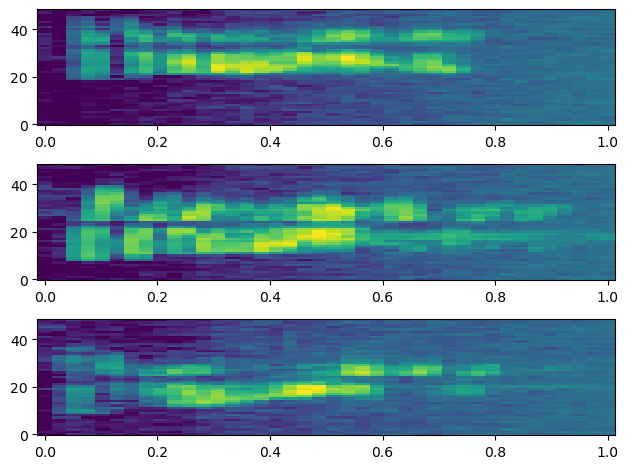

In [59]:
max_target_examples = 3
target_count = 0
target = tf.constant(0)
plt.Figure(figsize=(8,5))
for dat in ds_train.unbatch():
  # label_string = dat[1].numpy().decode('utf8')
  if dat[1] == target:
    target_count += 1
    ax = plt.subplot(max_target_examples, 1, target_count)
    # display.display(display.Audio(dat[0].numpy(), rate=16000))

    log_spec = dat[0].numpy()
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, 1.0, num=width, dtype=float)
    Y = range(height)
    ax.pcolormesh(X, Y, np.squeeze(log_spec))
    if target_count >= max_target_examples:
      break
plt.tight_layout()

In [26]:
## look at the label breakdown in the training set
# print(count_labels(ds_train))

## current count_labels is very slow.  some scratch code here towards
## implementing a faster one by converting labels to one-hot and then summing.
# tf.one_hot(indices, depth)
# ds_1hot = ds_train.map(lambda dat: tf.one_hot(dat[1], 3))
# xx = iter(ds_1hot).next()


## Build and Train Model

In [27]:
# import importlib
# importlib.reload(models)

<module 'keras_model' from '/Users/jeremy/dev/tiny_mlperf/tiny_main/benchmark/training/streaming_wakeword/keras_model.py'>

In [62]:
if load_pretrained_model:
  model = keras.models.load_model(pretrained_model_path)
else:
  model = models.get_model(args=Flags) # compile step is done inside get_model()


In [63]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 40)]          0         
                                                                 
 tf.expand_dims (TFOpLambda  (None, 49, 1, 40)         0         
 )                                                               
                                                                 
 depthwise_conv2d (Depthwis  (None, 45, 1, 40)         200       
 eConv2D)                                                        
                                                                 
 conv2d (Conv2D)             (None, 45, 1, 128)        5120      
                                                                 
 batch_normalization (Batch  (None, 45, 1, 128)        512       
 Normalization)                                                  
                                                             

In [64]:
if not load_pretrained_model:
  callbacks = util.get_callbacks(args=Flags)
  train_hist = model.fit(ds_train, validation_data=ds_val, callbacks=callbacks,
                         epochs=epochs)

In [65]:
save_model = False
if save_model:
  model.save('trained_models/streaming_ww_model_float.h5')

In [66]:
if not load_pretrained_model:
  plt.subplot(2,1,1)
  plt.semilogy(train_hist.epoch, train_hist.history['loss'], train_hist.history['val_loss'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.subplot(2,1,2)
  plt.plot(train_hist.epoch, train_hist.history['sparse_categorical_accuracy'], train_hist.history['val_sparse_categorical_accuracy'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')


In [78]:
model.evaluate(ds_val)

100/100 [==============================] - 2s 15ms/step - loss: 0.1171 - sparse_categorical_accuracy: 0.9905


[0.1171102523803711, 0.9904819130897522]

In [72]:
label_list = ['marvin', 'silent', 'other']
model_out = model.predict(ds_val)
y_pred_val = np.argmax(model_out, axis=1)

y_true_val = np.nan*np.zeros(y_pred_val.shape[0])
for i,dat in enumerate(ds_val.unbatch()):
  y_true_val[i] = dat[1]

acc = sum(y_pred_val == y_true_val) / len(y_true_val)
print(f'Validation set accuracy: {acc:.1%}')

100/100 [==============================] - 2s 14ms/step
Validation set accuracy: 99.0%


In [76]:
ds_train = ds_train.unbatch().batch(1)

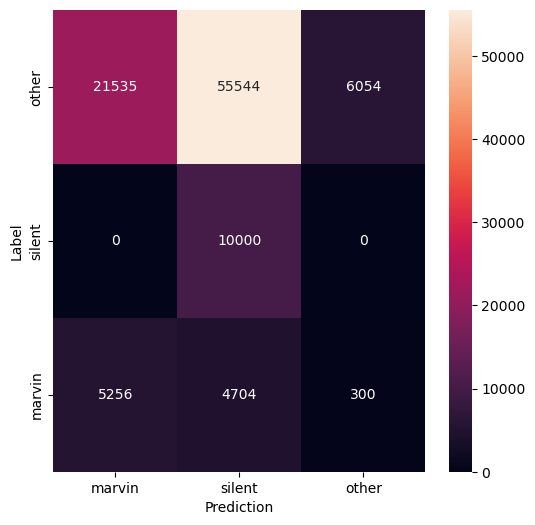

In [36]:

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Scratch Space


In [37]:
preproc_func = get_preprocess_audio_func(model_settings,is_training=True,
                                         background_data=background_data)

test_wav = rng.normal(size=(16000,1))
proc_wav_dict = preproc_func({'audio':example_wav, 'label':1})
                        

In [38]:
# tf.squeeze
# proc_wav_dict['audio']

In [39]:
for dat in ds_only_target.take(1):
  next_element = dat
is_training = True


desired_samples = model_settings['desired_samples']
background_frequency = model_settings['background_frequency']
background_volume_range_= model_settings['background_volume_range_']

wav_decoder = tf.cast(next_element['audio'], tf.float32)
if model_settings['feature_type'] != "td_samples":
  wav_decoder = wav_decoder/tf.reduce_max(wav_decoder)
else:
  wav_decoder = wav_decoder/tf.constant(2**15,dtype=tf.float32)
#Previously, decode_wav was used with desired_samples as the length of array. The
# default option of this function was to pad zeros if the desired samples are not found
wav_decoder = tf.pad(wav_decoder,[[0,desired_samples-tf.shape(wav_decoder)[-1]]]) 
# Allow the audio sample's volume to be adjusted.
foreground_volume_placeholder_ = tf.constant(1,dtype=tf.float32)

scaled_foreground = tf.multiply(wav_decoder,
                                foreground_volume_placeholder_)
# Shift the sample's start position, and pad any gaps with zeros.
time_shift_padding_placeholder_ = tf.constant([[2,2]], tf.int32)
time_shift_offset_placeholder_ = tf.constant([2],tf.int32)
scaled_foreground.shape
padded_foreground = tf.pad(scaled_foreground, time_shift_padding_placeholder_, mode='CONSTANT')
sliced_foreground = tf.slice(padded_foreground, time_shift_offset_placeholder_, [desired_samples])

if is_training and background_data != []:
  background_volume_range = tf.constant(background_volume_range_,dtype=tf.float32)
  background_index = np.random.randint(len(background_data))
  background_samples = background_data[background_index]
  background_offset = np.random.randint(0, len(background_samples) - desired_samples)
  background_clipped = background_samples[background_offset:(background_offset + desired_samples)]
  background_clipped = tf.squeeze(background_clipped)
  background_reshaped = tf.pad(background_clipped,[[0,desired_samples-tf.shape(wav_decoder)[-1]]])
  background_reshaped = tf.cast(background_reshaped, tf.float32)
  if np.random.uniform(0, 1) < background_frequency:
    background_volume = np.random.uniform(0, background_volume_range_)
  else:
    background_volume = 0
  background_volume_placeholder_ = tf.constant(background_volume,dtype=tf.float32)
  background_data_placeholder_ = background_reshaped
  background_mul = tf.multiply(background_data_placeholder_,
                       background_volume_placeholder_)
  background_add = tf.add(background_mul, sliced_foreground)
  sliced_foreground = tf.clip_by_value(background_add, -1.0, 1.0)

# apply preemphasis
preemphasis_coef = 1 - 2 ** -5
power_offset = 52
num_mel_bins = model_settings['dct_coefficient_count']
paddings = tf.constant([[0, 0], [1, 0]])
# for some reason, tf.pad only works with the extra batch dimension, but then we remove it after pad
sliced_foreground = tf.expand_dims(sliced_foreground, 0)
sliced_foreground = tf.pad(tensor=sliced_foreground, paddings=paddings, mode='CONSTANT')
sliced_foreground = sliced_foreground[:, 1:] - preemphasis_coef * sliced_foreground[:, :-1]
sliced_foreground = tf.squeeze(sliced_foreground) 
# compute fft
stfts = tf.signal.stft(sliced_foreground,  frame_length=model_settings['window_size_samples'], 
                       frame_step=model_settings['window_stride_samples'], fft_length=None,
                       window_fn=functools.partial(
                         tf.signal.hamming_window, periodic=False),
                       pad_end=False,
                       name='STFT')

# compute magnitude spectrum [batch_size, num_frames, NFFT]
magspec = tf.abs(stfts)
num_spectrogram_bins = magspec.shape[-1]

# compute power spectrum [num_frames, NFFT]
powspec = (1 / model_settings['window_size_samples']) * tf.square(magspec)
powspec_max = tf.reduce_max(input_tensor=powspec)
powspec = tf.clip_by_value(powspec, 1e-30, powspec_max) # prevent -infinity on log

def log10(x):
  # Compute log base 10 on the tensorflow graph.
  # x is a tensor.  returns log10(x) as a tensor
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

# Warp the linear-scale, magnitude spectrograms into the mel-scale.
lower_edge_hertz, upper_edge_hertz = 0.0, model_settings['sample_rate'] / 2.0
linear_to_mel_weight_matrix = (
    tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=model_settings['sample_rate'],
        lower_edge_hertz=lower_edge_hertz,
        upper_edge_hertz=upper_edge_hertz))
print(f"After powspec, shape = {powspec.shape}")

mel_spectrograms = tf.tensordot(powspec, linear_to_mel_weight_matrix,1)
print(f"After lin2mel, mel_spec shape = {log_mel_spec.shape}")

mel_spectrograms.set_shape(magspec.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))
print(f"After set_shape mel_spectrograms, shape = {mel_spectrograms.shape}")

log_mel_spec = 10 * log10(mel_spectrograms)
# log_mel_spec = tf.expand_dims(log_mel_spec, -1, name="mel_spec")

log_mel_spec = (log_mel_spec + power_offset - 32 + 32.0) / 64.0
log_mel_spec = tf.clip_by_value(log_mel_spec, 0, 1)
print(f"After log_mel_spec, shape = {log_mel_spec.shape}")
next_element['audio'] = log_mel_spec  


After powspec, shape = (49, 257)


NameError: name 'log_mel_spec' is not defined